In [1]:
import numpy as np
from NonlinearController.mpc_utils import *
from NonlinearController.controllers import *
from NonlinearController.model_utils import *
from NonlinearController.lpv_embedding import *
from NonlinearController.systems import UnbalancedDisc
import deepSI
import qpsolvers as qp
import torch
import random

In [2]:
##################  Utility functions  #######################

def differenceVector(X_1, nx):
    return X_1[nx:] - X_1[:-nx]

def extendABC(list_A, list_B, list_C, nx, ny):
    nz = nx+ny
    list_ext_A = np.zeros((nz*Nc,nz))
    list_ext_B = np.zeros((nz*Nc,nu))

    for i in range(Nc):
        list_ext_A[(i*nz):(i*nz+ny),:ny] = np.eye(ny)
        list_ext_A[(i*nz):(i*nz+ny),ny:nz] = list_C[(ny*i):(ny*i+ny),:]
        list_ext_A[(i*nz+ny):(i*nz+nz),ny:nz] = list_A[(nx*i):(nx*i+nx),:]

    for i in range(Nc):
        list_ext_B[(i*nz+ny):(i*nz+nz),:] = list_B[(nx*i):(nx*i+nx),:]

    list_ext_C = np.zeros((ny*Nc,nz))

    for i in range(Nc):
        list_ext_C[(i*ny):(i*ny+ny),:ny] = np.eye(ny)
        list_ext_C[(i*ny):(i*ny+ny),ny:nz] = list_C[(ny*i):(ny*i+ny),:]
    
    return list_ext_A, list_ext_B, list_ext_C

def extendState(Y_1, dX0, nx, ny):
    nz = nx+ny
    Z0 = np.zeros((Nc*nz,1))

    for i in range(Nc):
        Z0[(nz*i):(nz*i+ny),:] = Y_1[ny*i:(ny*i+ny),:]
        Z0[(nz*i+ny):(nz*i+nz),:] = dX0[nx*i:(nx*i+nx),:]

    return Z0

def decodeState(Z0, nx, ny):
    nz = nx+ny
    Y_1 = np.zeros((Nc*ny,1))
    dX0 = np.zeros((Nc*nx,1))

    for i in range(Nc):
        Y_1[ny*i:(ny*i+ny),:] = Z0[(nz*i):(nz*i+ny),:]
        dX0[nx*i:(nx*i+nx),:] = Z0[(nz*i+ny):(nz*i+nz),:]

    return Y_1, dX0

def extendReference(reference, nx, ny, Nc):
    nz = nx+ny

    r = np.zeros((Nc*nz,1))

    for i in range(Nc):
        r[nz*i,0] = reference[i]

    return r

def randomLevelReference(Nsim, nt_range, level_range):
    x_reference_list = np.array([])
    Nsim_remaining = Nsim
    while True:
        Nsim_steps = random.randint(nt_range[0],nt_range[1])
        Nsim_remaining = Nsim_remaining - Nsim_steps
        x_reference_list = np.hstack((x_reference_list, np.ones(Nsim_steps)*random.randint(level_range[0]*10,level_range[1]*10)/10))

        if Nsim_remaining <= 0:
            x_reference_list = x_reference_list[:Nsim]
            break
    return x_reference_list

In [3]:
##################  System  #######################
dt = 0.1
system = UnbalancedDisc(dt=dt)
system.reset_state()

##################  MPC variable specification  #######################
model = deepSI.load_system("NonlinearController/trained_models/unbalanced/UnbalancedDisk_dt01_nab_4_SNR_30_e150")
Nc=10; nr_iterations = 5; nr_sim_steps = 150

reference = randomLevelReference(nr_sim_steps+Nc, [25,30], [-1.5,1.5])
# reference = deepSI.deepSI.exp_design.multisine(nr_sim_steps+Nc+1, pmax=20, n_crest_factor_optim=20)/2.0

In [ ]:
# np.save("NonlinearController/references/setPoints.npy", reference)
# reference = np.load("NonlinearController/references/setPoints.npy")*1.5

In [4]:
##################  Offline Computation  #######################
nx = model.nx
nu = model.nu if model.nu is not None else 1
ny = model.ny if model.ny is not None else 1
nz = nx+ny
ne = 1

norm = model.norm

# initialize objective function matrices
R = np.eye(nu); Q = np.eye(nz)*1
Psi = get_Psi(Nc, R)
Omega = get_Omega(Nc, Q)
# extended objective matrices for soft constraints
e_lambda = 100000 # weighting of minimizing e in objective function
Ge = np.zeros((Nc*nu+ne,Nc*nu+ne))
Ge[-ne:,-ne:] = e_lambda

embedder = velocity_lpv_embedder(model, Nc, n_stages=20)

# normalize initial input and output
w0 = norm_input(0, norm)
q0 = norm_output(0, norm)

# initialize observer history input and output
nb = model.nb
uhist = torch.ones((1,nb))*w0
na = model.na
yhist = torch.ones((1,na))*q0

# initial predicted states, input, and output
X_1 = np.tile(model.encoder(uhist,yhist).detach().numpy(),Nc+1).T
U_1 = np.ones((Nc+1)*nu)[np.newaxis].T*w0
Y_1 = np.ones((Nc)*ny)[np.newaxis].T *q0

# determine constraint matrices
w_min = -4.0; w_max = 4.0
q_min = [-1.8, -10, -10]; q_max = [1.8, 10, 10]
u_min = norm_input(w_min, norm); u_max = norm_input(w_max, norm)
y_min = norm_output(q_min, norm); y_max = norm_output(q_max, norm)
D, E, M, c = getDEMc(y_min, y_max, u_min, u_max, Nc, nz, nu)
Lambda = np.tril(np.ones((Nc,Nc)),0)
# alpha = np.ones((Nc,1))*U_1[0,0]

##################  Logging  #######################
log_q = np.zeros((ny,nr_sim_steps))
log_w = np.zeros((nu,nr_sim_steps))
log_e = np.zeros((ne,nr_sim_steps))
log_iterations = np.zeros((1,nr_sim_steps))

In [5]:
##################  Online Computation  #######################

#++++++++++++++++++ start simulation step +++++++++++++++++++++++
for k in range(nr_sim_steps):
    # extend normalized reference to form of extended state
    r = extendReference(norm_output(reference[k:k+Nc], norm), nx, ny, Nc)
    
    #++++++++++++++++++ start iteration +++++++++++++++++++++++
    for iteration in range(nr_iterations):
        # determine predicted velocity states and output
        dX0 = differenceVector(X_1, nx)
        dU0 = differenceVector(U_1, nu)
        # determine extended state from predicted output and velocity states
        Z0 = extendState(Y_1, dX0, nx, ny)

        # determine lpv state space dependencies
        list_A, list_B, list_C = embedder(X_1, U_1)
        list_ext_A, list_ext_B, list_ext_C = extendABC(list_A, list_B, list_C, nx, ny)

        # describe optimization problem
        Phi = get_Phi(list_ext_A, Nc, nz)
        Gamma = get_Gamma(list_ext_A, list_ext_B, Nc, nz, nu)
        G = Psi + Gamma.T @ Omega @ Gamma
        F = 2*Gamma.T @ Omega.T @ (Phi @ Z0[:nz] - r)
        L = (M @ Gamma + E @ Lambda) #@ dU0
        alpha = np.ones((Nc,1))*U_1[0,0]
        W = -(E @ alpha + (D + M @ Phi) @ Z0[:nz])
        # add soft constraints
        Ge[:Nc*nu, :Nc*nu] = G
        Fe = np.vstack((F, np.zeros((ne,1))))
        Le = np.hstack((L, -np.ones((Nc*2*(nz+nu)+2*nz,ne))))
        # solve for optimal U over prediction horizon
        opt_result = qp.solve_qp(Ge,Fe,Le,c+W,solver="osqp")
        # dU0[:,0] = qp.solve_qp(G,F,solver="osqp")
        # split optimization result in optimal input and soft bound variable e
        dU0[:,0] = opt_result[:Nc*nu]
        e = opt_result[-ne]
        # e=1
        

        # predict states
        Z1 = Phi @ Z0[:nz] + Gamma @ dU0
        # split extended state up into ouputs and velocity states
        Y0, dX1 = decodeState(Z1, nx, ny)
        # overwrite previous predicted states and output with new predicted states and output
        Y_1[ny:,0] = Y0[:-ny,0]; dX0[nx:,0] = dX1[:-nx,0]
        # save previous iteration of U_1
        U_1_old = np.copy(U_1)
        # determine new X_1 states from known x0 and predicted dX0
        for i in range(2,Nc+1):
            X_1[(i*nx):(i*nx+nx),:] = dX0[((i-1)*nx):((i-1)*nx+nx),:] + X_1[((i-1)*nx):((i-1)*nx+nx),:]
        for i in range(2,Nc+1):
            U_1[(i*nu):(i*nu+nu),:] = dU0[((i-1)*nu):((i-1)*nu+nu),:] + U_1[((i-1)*nu):((i-1)*nu+nu),:]

        # stopping condition
        if np.linalg.norm(U_1 - U_1_old) < 1e-1:
            break
    #++++++++++++++++++ end iteration +++++++++++++++++++++++
    
    # determine input from optimal velocity input
    u0 = dU0[:nu,0] + U_1[:nu,0]
    # denormalize input
    w0 = denorm_input(u0, norm)
    # measure output then apply input
    q0 = system.measure_act(w0[0]) # maybe change this to act measure / deal with dimension of input
    # normalize output
    y0 = norm_output(q0, norm)

    # shift history input and output for encoder
    for j in range(nb-1):
        uhist[0,j] = uhist[0,j+1]
    uhist[0,nb-1] = torch.Tensor(u0)
    for j in range(na-1):
        yhist[0,j] = yhist[0,j+1]
    yhist[0,na-1] = torch.Tensor([y0])
    # predict state with encoder
    x1 = model.encoder(uhist,yhist)

    # shift predicted states, input, and output one time step k
    X_1[:-nx, 0] = X_1[nx:, 0]; X_1[-nx:, 0] = X_1[-2*nx:-nx, 0]; X_1[nx:2*nx, 0] = x1.detach().numpy()
    U_1[:-nu, 0] = U_1[nu:, 0]; U_1[-nu:, 0] = U_1[-2*nu:-nu, 0]; U_1[:nu, 0] = u0
    Y_1[:-ny, 0] = Y_1[ny:, 0]; Y_1[-ny:, 0] = Y_1[-2*ny:-ny, 0]; Y_1[:ny, 0] = y0

    # log system signals
    log_q[:,k] = q0
    log_w[:,k] = w0
    log_e[:,k] = e
    log_iterations[:,k] = iteration+1
    
    # print progress
    print("Sim step: " + str(k) + ", iterations: " + str(iteration+1))
    
#++++++++++++++++++ end simulation step +++++++++++++++++++++++

c:\Users\20182739\AppData\Local\Programs\Python\Python39\lib\site-packages\qpsolvers\solvers\typing.py:48: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(
c:\Users\20182739\AppData\Local\Programs\Python\Python39\lib\site-packages\qpsolvers\solvers\typing.py:48: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(


Sim step: 0, iterations: 1
Sim step: 1, iterations: 5
Sim step: 2, iterations: 5
Sim step: 3, iterations: 5
Sim step: 4, iterations: 5
Sim step: 5, iterations: 2
Sim step: 6, iterations: 5
Sim step: 7, iterations: 4
Sim step: 8, iterations: 5
Sim step: 9, iterations: 4
Sim step: 10, iterations: 5
Sim step: 11, iterations: 4
Sim step: 12, iterations: 2
Sim step: 13, iterations: 2
Sim step: 14, iterations: 2
Sim step: 15, iterations: 1
Sim step: 16, iterations: 1
Sim step: 17, iterations: 1
Sim step: 18, iterations: 1
Sim step: 19, iterations: 1
Sim step: 20, iterations: 4
Sim step: 21, iterations: 3
Sim step: 22, iterations: 3
Sim step: 23, iterations: 3
Sim step: 24, iterations: 3
Sim step: 25, iterations: 5
Sim step: 26, iterations: 3
Sim step: 27, iterations: 5
Sim step: 28, iterations: 5
Sim step: 29, iterations: 5
Sim step: 30, iterations: 5
Sim step: 31, iterations: 4
Sim step: 32, iterations: 5
Sim step: 33, iterations: 5
Sim step: 34, iterations: 4
Sim step: 35, iterations: 3
Si

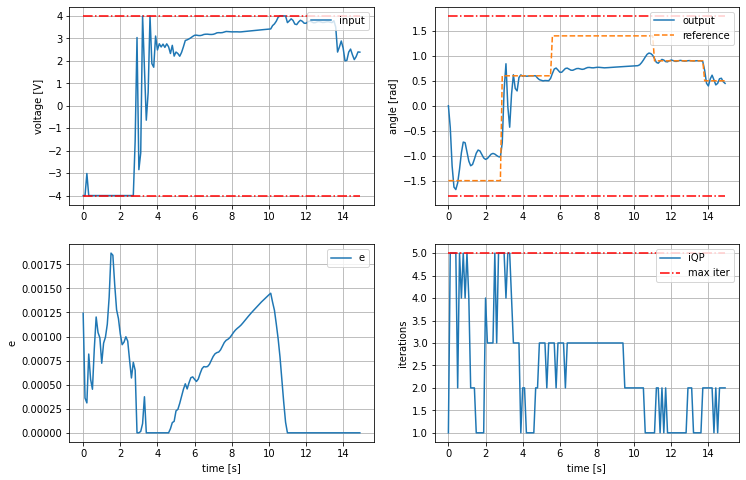

In [6]:
fig1 = plt.figure(figsize=[12, 8])

plt.subplot(2,2,1)
plt.plot(np.arange(nr_sim_steps)*dt, log_w[0,:], label='input')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*w_max, 'r-.')#, label='max')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*w_min, 'r-.')#, label='min')
# plt.xlabel("time [s]")
plt.ylabel("voltage [V]")
plt.grid()
plt.legend(loc='upper right')

plt.subplot(2,2,2)
plt.plot(np.arange(nr_sim_steps)*dt, log_q[0,:], label='output')
plt.plot(np.arange(nr_sim_steps)*dt, reference[:nr_sim_steps], '--', label='reference')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*q_max[0], 'r-.')#, label='max')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*q_min[0], 'r-.')#, label='min')
# plt.xlabel("time [s]")
plt.ylabel("angle [rad]")
plt.grid()
plt.legend(loc='upper right')

plt.subplot(2,2,3)
plt.plot(np.arange(nr_sim_steps)*dt, log_e[0,:], label='e')
plt.xlabel("time [s]")
plt.ylabel("e")
plt.grid()
plt.legend(loc='upper right')

plt.subplot(2,2,4)
plt.plot(np.arange(nr_sim_steps)*dt, log_iterations[0,:], label='iQP')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*nr_iterations, 'r-.', label='max iter')
plt.xlabel("time [s]")
plt.ylabel("iterations")
plt.grid()
plt.legend(loc='upper right')

plt.show()